# Turbine Operation Models

Separate from the turbine models, which define the physical characterstics of the turbines, FLORIS
allows users to specify how the turbine behaves in terms of producing power and thurst. We refer to 
different models for turbine behavior as "operation models". A key feature of operation models is
the ability for users to specify control setpoints at which the operation model will be evaluated. 
For instance, some operation models allow users to specify `yaw_angles`, which alter the power 
being produced by the turbine along with it's thrust force on flow.

Operation models are specified by the `operation_model` key on the turbine yaml file, or by using
the `set_operation_model()` method on `FlorisModel`. Each operation model available in FLORIS is
described and demonstrated below. The simplest operation model is the `"simple"` operation model,
which takes no control setpoints and simply evaluates the power and thrust coefficient curves for 
the turbine at the current wind condition. The default operation model is the `"cosine-loss"`
operation model, which models the loss in power of a turbine under yaw misalignment using a cosine
term with an exponent.

We first provide a quick demonstration of how to switch between different operation models. Then, 
each operation model available in FLORIS is described, along with its relevant control setpoints.
We also describe the different parameters that must be specified in the turbine 
`"power_thrust_table"` dictionary in order to use that operation model.

## Selecting the operation model

There are two options for selecting the operation model:
1. Manually changing the `"operation_model"` field of the turbine input yaml 
(see [Turbine Input File Reference](input_reference_turbine))

2. Using `set_operation_model()` on an instantiated `FlorisModel` object.

The following code demonstrates the use of the second option.

simple operation model powers (kW):  [[1753.95445918  436.4427005   506.66815478]]
cosine-loss operation model powers [kW]:  [[1561.31837381  778.04338242  651.77709894]]


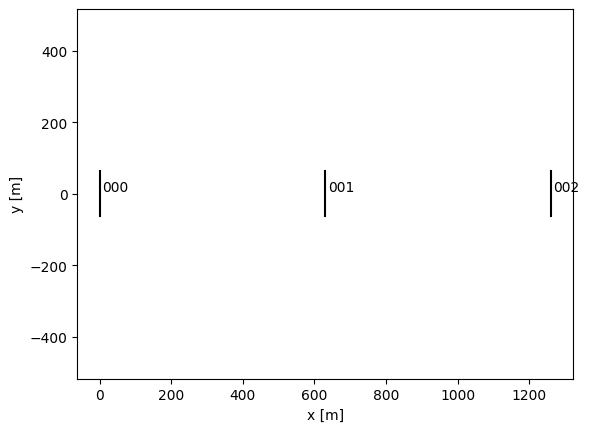

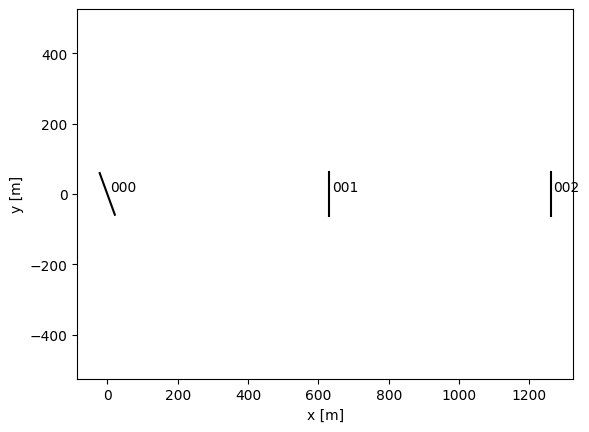

In [1]:
from floris import FlorisModel
from floris import layout_visualization as layoutviz

fmodel = FlorisModel("../examples/inputs/gch.yaml")

# Look at layout
ax = layoutviz.plot_turbine_rotors(fmodel)
layoutviz.plot_turbine_labels(fmodel, ax=ax)
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")

# Set simple operation model
fmodel.set_power_thrust_model("simple")

# Evalaute the model and extract the power output
fmodel.run()
print("simple operation model powers (kW): ", fmodel.get_turbine_powers() / 1000)

# Set the yaw angles (which the "simple" operation model does not use
# and change the operation model to "cosine-loss"
fmodel.set(yaw_angles=[[20., 0., 0.]])
fmodel.set_power_thrust_model("cosine-loss")
ax = layoutviz.plot_turbine_rotors(fmodel)
layoutviz.plot_turbine_labels(fmodel, ax=ax)
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")

# Evaluate again
fmodel.run()
powers_cosine_loss = fmodel.get_turbine_powers()
print("cosine-loss operation model powers [kW]: ", fmodel.get_turbine_powers() / 1000)


## Operation model library

### Simple model
User-level name: `"simple"`

Underlying class: `SimpleTurbine`

Required data on `power_thrust_table`:
- `ref_air_density` (scalar)
- `ref_tilt` (scalar)
- `wind_speed` (list)
- `power` (list)
- `thrust_coefficient` (list)

The `"simple"` operation model describes the "normal" function of a wind turbine, as described by
its power curve and thrust coefficient. It does not respond to any control setpoints, and is most 
often used as a baseline or for users wanting to evaluate wind farms in nominal operation.

### Cosine loss model
User-level name: `"cosine-loss"`

Underlying class: `CosineLossTurbine`

Required data on `power_thrust_table`:
- `ref_air_density` (scalar)
- `ref_tilt` (scalar)
- `wind_speed` (list)
- `power` (list)
- `thrust_coefficient` (list)
- `cosine_loss_exponent_yaw` (scalar)
- `cosine_loss_exponent_tilt` (scalar)

The `"cosine-loss"` operation model describes the decrease in power and thrust produced by a 
wind turbine as it yaws (or tilts) away from the incoming wind. The thrust is reduced by a factor of 
$\cos \gamma$, where $\gamma$ is the yaw misalignment angle, while the power is reduced by a factor 
of $(\cos\gamma)^{p_P}$, where $p_P$ is the cosine loss exponent, specified by `cosine_loss_exponent_yaw`
(or `cosine_loss_exponent_tilt` for tilt angles). The power and thrust produced by the turbine
thus vary as a function of the turbine's yaw angle, set using the `yaw_angles` argument to 
`FlorisModel.set()`.

Text(0, 0.5, 'Power [kW]')

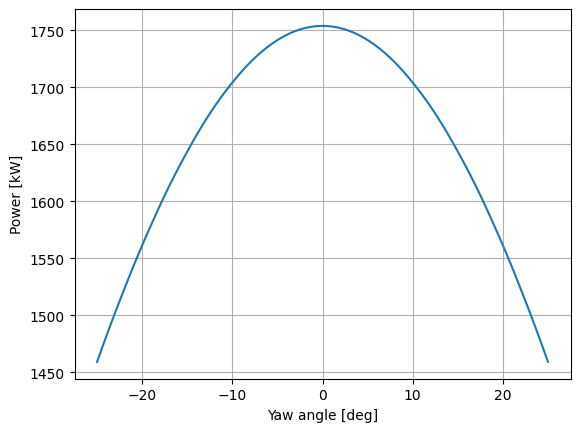

In [2]:
from floris import TimeSeries
import numpy as np
import matplotlib.pyplot as plt

# Set up the FlorisModel
fmodel.set_power_thrust_model("cosine-loss")
fmodel.set(layout_x=[0.0], layout_y=[0.0])
fmodel.set(
    wind_data=TimeSeries(
        wind_speeds=np.ones(100) * 8.0,
        wind_directions=np.ones(100) * 270.0,
        turbulence_intensities=0.06
    )
)
fmodel.reset_operation()

# Sweep the yaw angles
yaw_angles = np.linspace(-25, 25, 100)
fmodel.set(yaw_angles=yaw_angles.reshape(-1,1))
fmodel.run()

powers = fmodel.get_turbine_powers()/1000

fig, ax = plt.subplots()
ax.plot(yaw_angles, powers)
ax.grid()
ax.set_xlabel("Yaw angle [deg]")
ax.set_ylabel("Power [kW]")

### Simple derating model
User-level name: `"simple-derating"`

Underlying class: `SimpleDeratingTurbine`

Required data on `power_thrust_table`:
- `ref_air_density` (scalar)
- `ref_tilt` (scalar)
- `wind_speed` (list)
- `power` (list)
- `thrust_coefficient` (list)

The `"simple-derating"` operation model enables users to derate turbines by setting a new power 
rating. It does not require any extra parameters on the `power_thrust_table`, but adescribes the 
decrease in power and thrust produced by providing the `power_setpoints` argument to
`FlorisModel.set()`. The default power rating for the turbine can be acheived by setting the
appropriate entries of `power_setpoints` to `None`.

/Users/msinner/floris3/floris/core/turbine/operation_models.py:367: RuntimeWarning: divide by zero encountered in divide
  power_fractions = power_setpoints / base_powers
/Users/msinner/floris3/floris/core/wake_deflection/gauss.py:323: RuntimeWarning: invalid value encountered in divide
  val = 2 * (avg_v - v_core) / (v_top + v_bottom)
/Users/msinner/floris3/floris/core/wake_deflection/gauss.py:158: RuntimeWarning: invalid value encountered in divide
  C0 = 1 - u0 / freestream_velocity
/Users/msinner/floris3/floris/core/wake_velocity/gauss.py:80: RuntimeWarning: invalid value encountered in divide
  sigma_z0 = rotor_diameter_i * 0.5 * np.sqrt(uR / (u_initial + u0))


Text(0, 0.5, 'Power [kW]')

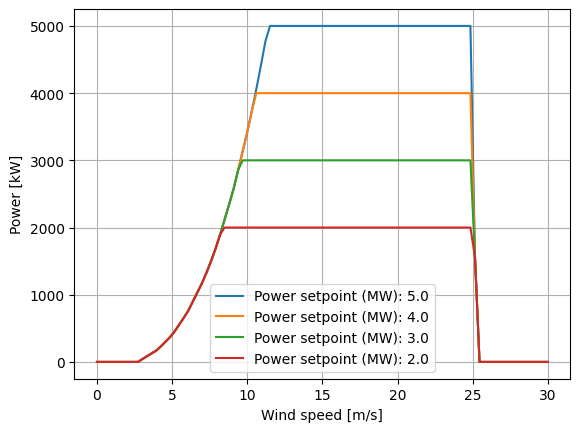

In [3]:
# Set up the FlorisModel
fmodel.set_power_thrust_model("simple-derating")
fmodel.reset_operation()
wind_speeds = np.linspace(0, 30, 100)
fmodel.set(
    wind_data=TimeSeries(
        wind_speeds=wind_speeds,
        wind_directions=np.ones(100) * 270.0,
        turbulence_intensities=0.06
    )
)

fig, ax = plt.subplots()
for power_setpoint in [5.0, 4.0, 3.0, 2.0]:
    fmodel.set(power_setpoints=np.array([[power_setpoint*1e6]]*100))
    fmodel.run()
    powers = fmodel.get_turbine_powers()/1000
    ax.plot(wind_speeds, powers[:,0], label=f"Power setpoint (MW): {power_setpoint}")

ax.grid()
ax.legend()
ax.set_xlabel("Wind speed [m/s]")
ax.set_ylabel("Power [kW]")

### Mixed operation model
User-level name: `"mixed"`

Underlying class: `MixedOperationTurbine`

Required data on `power_thrust_table`:
- `ref_air_density` (scalar)
- `ref_tilt` (scalar)
- `wind_speed` (list)
- `power` (list)
- `thrust_coefficient` (list)
- `cosine_loss_exponent_yaw` (scalar)
- `cosine_loss_exponent_tilt` (scalar)

The `"mixed"` operation model allows users to specify _either_ `yaw_angles` (evaluated using the 
`"cosine-loss"` operation model) _or_ `power_setpoints` (evaluated using the `"simple-derating"`
operation model). That is, for each turbine, and at each `findex`, a non-zero yaw angle or a 
non-`None` power setpoint may be specified. However, specifying both a non-zero yaw angle and a 
finite power setpoint for the same turbine and at the same `findex` will produce an error.

In [4]:
fmodel.set_power_thrust_model("mixed")
fmodel.set(layout_x=[0.0, 0.0], layout_y=[0.0, 500.0])
fmodel.reset_operation()
fmodel.set(
    wind_data=TimeSeries(
        wind_speeds=np.array([10.0]),
        wind_directions=np.array([270.0]),
        turbulence_intensities=0.06
    )
)
fmodel.set(
    yaw_angles=np.array([[20.0, 0.0]]),
    power_setpoints=np.array([[None, 2e6]])
)
fmodel.run()
print("Powers [kW]: ", fmodel.get_turbine_powers()/1000)

Powers [kW]:  [[3063.49046772 2000.        ]]
